# Amazon Bedrock onboarding notebook

This notebook provides steps requried to install Bedrock SDK, dependencies and other pre-requisistes before API calls can be made.
It also provides sample code to access LLMs, text to image, embeddings and streaming support

(This notebook was tested on SageMaker Studio ml.m5.2xlarge instance with Datascience 3.0 kernel)


## Service access checklist
Before you proceed further, ensure following steps are carried out: 

* Ensure that you have access to Amazon Bedrock service in your account and the region you are launching these notebooks
* Review Amazon Bedrock service user guide. You can access the user guide [here.](https://d2eo22ngex1n9g.cloudfront.net/Documentation/BedrockUserGuide.pdf)
* Subscribe to the models you plan to utilize. This requires subscription to the models from AWS Marketplace for third-party models. If your account is setup with Private Marketplace, you need to subscribe to the model Ids and they need to be part of the Private Marketplace products. Refer to Bedrock User guide for details.
* Fill-out forms on Bedrock servie console to get access to the models. The access forms can be filled-in from Playground page on Amazon Bedrock console page. The subscription requests take few days and you would see a message "Request Pending" in Playground page until the approval is received.
* Setup IAM policies to get access to Amazon Bedrock service. You can refer to Bedrock User Guide for a list of actions.

## Pre-requisites

In [2]:
#Check Python version is greater than 3.8 which is required by Langchain if you want to use Langchain
import sys
sys.version

'3.10.6 (main, Oct  7 2022, 20:19:58) [GCC 11.2.0]'

In [3]:
assert sys.version_info >= (3, 8)

## Step 1 - Make sure you have latest boto3 SDK

In [ ]:
!pip install boto3 --upgrade

### Verify boto3 installation

In [ ]:
#!aws bedrock list-foundation-models 
!aws --version

## Step 2- Restart Kernel

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

## Step 3- Attach policies to IAM role to permission Bedrock service

In [4]:
import sagemaker
import boto3
session = boto3.Session()
sagemaker_session = sagemaker.Session()
studio_region = sagemaker_session.boto_region_name 
#sagemaker_session.get_caller_identity_arn()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


First add a policy to the role listed above similar to:
    
```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "Bedrock",
            "Effect": "Allow",
            "Action": "bedrock:*",
            "Resource": "*"
        }
    ]
}
```

## Step 4 - Test bedrock boto3 install

In [5]:
# Configure your AWS credentials using the aws configure command, or pass them to the boto3 client
br = boto3.client('bedrock-runtime' , 'us-east-1', endpoint_url='https://bedrock.us-east-1.amazonaws.com')

bedrock = boto3.client('bedrock' , 'us-east-1', endpoint_url='https://bedrock.us-east-1.amazonaws.com')
bedrock.list_foundation_models()

{'ResponseMetadata': {'RequestId': '42a0e241-7739-4503-ad8c-7c6d4a87cbd7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 13 Oct 2023 18:32:30 GMT',
   'content-type': 'application/json',
   'content-length': '5729',
   'connection': 'keep-alive',
   'x-amzn-requestid': '42a0e241-7739-4503-ad8c-7c6d4a87cbd7'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-tg1-large',
   'modelId': 'amazon.titan-tg1-large',
   'modelName': 'Titan Text Large',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities': ['TEXT'],
   'responseStreamingSupported': True,
   'customizationsSupported': ['FINE_TUNING'],
   'inferenceTypesSupported': ['ON_DEMAND']},
  {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-e1t-medium',
   'modelId': 'amazon.titan-e1t-medium',
   'modelName': 'Titan Text Embeddings',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities'

In [6]:
[m['modelId'] for m in bedrock.list_foundation_models()['modelSummaries']]

['amazon.titan-tg1-large',
 'amazon.titan-e1t-medium',
 'amazon.titan-embed-g1-text-02',
 'amazon.titan-text-express-v1',
 'amazon.titan-embed-text-v1',
 'stability.stable-diffusion-xl',
 'stability.stable-diffusion-xl-v0',
 'ai21.j2-grande-instruct',
 'ai21.j2-jumbo-instruct',
 'ai21.j2-mid',
 'ai21.j2-mid-v1',
 'ai21.j2-ultra',
 'ai21.j2-ultra-v1',
 'anthropic.claude-instant-v1',
 'anthropic.claude-v1',
 'anthropic.claude-v2',
 'cohere.command-text-v14']

## Step 5- Test Foundation models 

In [7]:
import json
prompt = """Command: Write me a blog about making strong business decisions as a leader.\nBlog:"""

### Evaluate Titan Large

In [8]:
body = json.dumps({"inputText": prompt})
modelId = "amazon.titan-tg1-large"  
accept = "application/json"
contentType = "application/json"

response = br.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("results")[0].get("outputText"))

 Making strong business decisions as a leader requires a combination of strategic thinking, data analysis, and insight into the needs and goals of the organization. Here are some tips to help leaders make informed and effective business decisions:
Define clear objectives: Before making any business decision, it's important to clearly define what you hope to achieve. This ensures that all decisions align with the organization's overall objectives and goals.
Gather relevant data: Collect and analyze data related to the decision you need to make. This could include financial data, market trends, customer feedback, and insights from your team.
Consider multiple perspectives: Engage with stakeholders and consider


### Evaluate Anthropic Claude Instant

In [9]:
prompt_formatted = 'Human:\n' + prompt + 'Assistant:\n'
body = json.dumps({"prompt": prompt_formatted, "max_tokens_to_sample": 500})
modelId = "anthropic.claude-instant-v1"  
accept = "application/json"
contentType = "application/json"

response = br.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("completion"))

 Here is a draft blog post on making strong business decisions as a leader:

**Title: 5 Tips for Making Strong Business Decisions as a Leader**

As a leader, making decisions that positively impact your business is one of the most important responsibilities of your role. However, making high-stakes choices that everyone will agree with can be challenging. Here are some tips for making strong business decisions that move your company in the right direction:

**Consider multiple perspectives.** Gather input from different parts of your organization before committing to a course of action. Hearing different viewpoints helps you spot potential issues or unintended consequences you may have overlooked. It also builds buy-in for your ultimate decision.

**Analyze data and facts objectively.** Don't rely solely on gut feelings or past precedents. Take the time to examine relevant financials, market research, case studies or other empirical evidence that can guide you. Data prevents subjective

### Evaluate AI21 Jurassic Grande

In [10]:
body = json.dumps({"prompt": prompt, "maxTokens": 200})
modelId = "ai21.j2-grande-instruct"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

response = br.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("completions")[0].get("data").get("text"))



Making strong business decisions as a leader is essential for achieving long-term success and growth. Whether you're facing an ambush by a competitor or dealing with internal team conflicts, being a strong leader can help you overcome challenges and foster a positive working environment.

In this blog post, we will discuss some key factors that contribute to making strong business decisions as a leader. By understanding these factors, you will gain confidence in your decision-making abilities and ultimately achieve better results for your business.

Firstly, it's important to have a clear understanding of the goals and objectives of your business. This means having a clear vision for the future and being able to articulate it to your team. When faced with difficult decisions, referring to your business goals and objectives can help you make informed decisions that align with your long-term vision.

Secondly, it's important to have a diverse and experienced team. Strong leaders unders

### Evaluate Titan Embeddings

In [12]:
body = json.dumps({"inputText": prompt})
modelId = "amazon.titan-e1t-medium"  
accept = "application/json"
contentType = "application/json"

response = br.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

embedding = response_body.get("embedding")
print(f"The embedding vector has {len(embedding)} values\n{embedding[0:3]+['...']+embedding[-3:]}")

The embedding vector has 4096 values
[0.796875, 0.20214844, 0.11035156, '...', 0.15722656, 0.11621094, 0.43164062]


### Evaluate Stable Diffusion Model

In [13]:
prompt_data = "a fine image of an astronaut riding a horse on Mars"
body = json.dumps({
  "text_prompts": [
    { 
      "text": prompt_data 
    }
  ],
  "cfg_scale":10,
  "seed":20,
  "steps":50
})
modelId = "stability.stable-diffusion-xl" 
accept = "application/json"
contentType = "application/json"

response = br.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body['result'])
print(f'{response_body.get("artifacts")[0].get("base64")[0:80]}...')

success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAABrGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


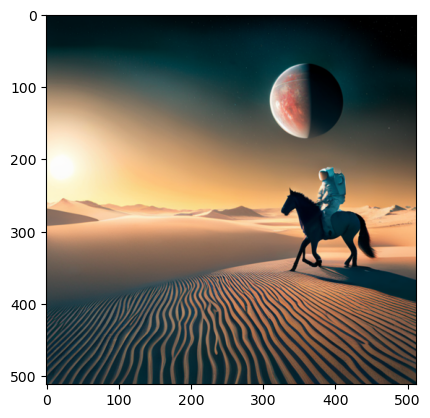

In [14]:
import io, base64
from matplotlib.pyplot import imshow
from PIL import Image
base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
imshow(image)

### Streaming Response

In [15]:
from IPython.display import display, display_markdown, Markdown, clear_output

prompt = """Command: Write me a blog about making strong business decisions as a leader.\nBlog:"""
prompt_formatted = 'Human:\n' + prompt + 'Assistant:\n'


body = json.dumps({"prompt": prompt_formatted, "max_tokens_to_sample": 200})
modelId = "anthropic.claude-instant-v1"  
accept = "application/json"
contentType = "application/json"

response = br.invoke_model_with_response_stream(body=body, modelId=modelId, accept=accept, contentType=contentType)
stream = response.get('body')
output = []

if stream:
    for event in stream:
        chunk = event.get('chunk')
        if chunk:
            chunk_obj = json.loads(chunk.get('bytes').decode())
            text = chunk_obj['completion']
            clear_output(wait=True)
            output.append(text)
            display_markdown(Markdown(''.join(output)))

 Here is a draft blog post on making strong business decisions as a leader:

## Making Strong Business Decisions as a Leader

As a leader, one of your primary responsibilities is to make decisions that move your business in a positive direction. However, making the right calls is often easier said than done, as there are always multiple factors to consider and the outcome is uncertain. Here are some tips for making solid business decisions that will help establish you as a strong leader.

### Consider Multiple Perspectives

When facing an important decision, don't rely solely on your own judgment. Make sure to gather input from individuals across your organization who will be impacted. This includes those directly involved in operations as well as support roles. Getting a diversity of perspectives will help uncover potential issues or opportunities you may have otherwise overlooked.

### Analyze Data and Research Options Thoroughly  

Don't rush into a choice before doing your due diligence. Take the time to analyze relevant data